# **Un'Analisi Quantitativa e Visiva del Restauro Audio Zero-Shot con Demucs**

Progetto di: Aurora Di Giovanna\
Matricola: 2127738 \
Email universitaria: digiovanna.2127738@studenti.uniroma1.it

In [4]:
# @title 1.1 Installazione delle dipendenza essenziali
!pip install -U demucs gradio pydub
!pip install pydub
print("\nInstallazione completata!")
!pip install -U torchmetrics


Installazione completata!


In [5]:
from pathlib import Path
import librosa
import numpy as np
import shutil
import pandas as pd
from pydub import AudioSegment
from scipy.signal import butter, lfilter
from scipy.signal import resample_poly
import soundfile as sf
import subprocess
import matplotlib.pyplot as plt
import librosa.display
import torch
import torchaudio
from torchmetrics.audio import SignalDistortionRatio, SignalNoiseRatio, ScaleInvariantSignalDistortionRatio

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [6]:
Path("audio_dataset/clean").mkdir(exist_ok=True, parents=True)
Path("audio_dataset/degraded").mkdir(exist_ok=True, parents=True)
Path("restored_outputs").mkdir(exist_ok=True, parents=True)
print("Cartelle create o già esistenti")

Cartelle create o già esistenti


## **2.2 Esecuzione: Sourcing creazione del Dataset degradato**


Nella seguente cella viene preparato il dataset audio. Per prima cosa utilizzo la librieria *"Librosa"* per ricavare tre file audio puliti di esempio. Successivamente converto il formato Ogg -> Wav e creo il percorso di destinazione per ogni file convertito. Inoltre creo un blocco try-except per catturare i possibili errori.

In [7]:
print("Sourcing e conversione dei dati audio da Librosa a WAV...") # Prendiamo gli esempi da "librosa"
example_names = ['nutcracker', 'vibeace', 'brahms']
clean_dir = Path("audio_dataset/clean") # Percorso per le canzoni clean date in input

for name in example_names: # Per ogni nome nella lista example_names
    source_path_ogg = librosa.ex(name) # Prendo il path originale .ogg

    # Creiamo un nome file di destinazione che finisce con .wav
    dest_path_wav = clean_dir / Path(source_path_ogg).with_suffix('.wav').name # Creo un file con lo stesso nome ma in .wav

    try:
        print(f"Convertendo '{Path(source_path_ogg).name}' in '{dest_path_wav.name}'...")
        audio = AudioSegment.from_file(source_path_ogg)

        audio.export(dest_path_wav, format="wav") # Converto definitivamente il file .ogg -> .wav

    except Exception as e:
        print(f"  !!! ERRORE durante la conversione di {name}: {e}") # Se il blocco try non può essere eseguito il nostro errore viene "catturato" da Exception as e

print("I dati esempio sono pronti in formato .WAV")



Sourcing e conversione dei dati audio da Librosa a WAV...
Convertendo 'Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy.ogg' in 'Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy.wav'...


Convertendo 'Kevin_MacLeod_-_Vibe_Ace.ogg' in 'Kevin_MacLeod_-_Vibe_Ace.wav'...


Convertendo 'Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra).ogg' in 'Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra).wav'...
I dati esempio sono pronti in formato .WAV


## **2.2 Definizioni: Utilità audio e Pipeline di degrado**
A seguire vado a definire tutte le funzioni utili per gestire i file audio:


*   ***ensure_dir(p: Path)***: questa funzione verifica se un path di directory esiste, altrimenti lo crea;
*   ***valid_audio(x: np.ndarray)***: questa funzione svolge una serie di controlli per controllare un array NumPy:

      *   Verifica dell'input;
      *   Controllo dell'audio: mono o stereo;
      *   Controllo dei valori speciali (NaN o Inf);
      *   Verifica che l'array non sia vuoto.
* ***save_wav_safe(path: Path, audio: np.ndarray, sr: int)*** : questa funzione salva il file WAV nel path specifico con una frequenza di campionamento (sr). Previene la distorsione applicando np.clip e limitando i valori.
* ***load_mono(path: Path, sr: int)***: questa funzione carica un file audio da un path usando Librosa e si assicura della conversione e del ricampionamento con la giusta frequenza di campionamento (sr).







In [8]:

# Funzioni utili

def ensure_dir(p: Path): # Questa funzione prende in input un percorso e si assucura che esista.
    p.mkdir(parents=True, exist_ok=True)

def valid_audio(x: np.ndarray): # Questa funzione controlla la qualità dell'audio, evitando così che entrino file corrotti ella p
    return (
        isinstance(x, np.ndarray) # Controlla se l'array è un array NumPy
        and x.ndim in (1,2) # Controlla se l'audio è mono 1D o stereo 2D
        and np.isfinite(x).all() # Controlla se nell'array ci sono numeri particolari come NaN e infinito
        and len(x) > 0 # Controlla se l'array è vuoto
        and np.max(np.abs(x)) > 0 # Controlla se l'audio è completamente silenzioso
    )

def save_wav_safe(path: Path, audio: np.ndarray, sr: int): # Questa funzione salva il file wav
    if audio.ndim == 1:
        audio = audio[:, None]
    audio = np.clip(audio, -1.0, 1.0) # In questa riga il segnale audio che è più forte di 1.0 e più debole di -1.0 viene tagliato, per prevenire il clipping (distorsione)
    sf.write(str(path), audio, sr, subtype='PCM_16') # Il file viene salvato a 16bit

def load_mono(path: Path, sr: int): # Questa funzione carica un file audio usando librosa
    x, sr0 = librosa.load(str(path), sr=sr, mono=True) # assicurandosi che l'audio sia convertito in mono e con la giusta frequenza
    return x, sr

Adesso inizializzo tutte le funzioni utili per la mia pipeline di degrado:


*   ***butter_lpf(x, sr, cutoff)***: questa funzione applica un filtro passa-basso di Butterworth il quale elimina le frequenze sopra una certa soglia, il cutoff (normalizzato rispetto alla frequenza di campionamento);
*  ***quantize_8bit_tpdf(x, rng)***: questa funzione riduce la risoluzione dell'ampiezza dell'audio aggiungendo un errore di quantizzazione. Per evitare la distorsione viene aggiunto il dither, un rumore che usa una distribuzione traingolare;
* ***add_noise_snr(x, snr_db, rng)***: questa funzione aggiunge rumore al segnale audio in base al Signal-to-noise Ratio (SNR), una misura che confronta potenza del segnare con quella del rumore di fondo;
* ***degrade_chain(x, sr, down_sr=16000, cutoff_hz=7000, snr_db=25, seed=0)*** : questa è una funzione principale che costruisce la pipeline di restauro usando le funzioni precedentemente descritte.



In [9]:
# Qui inizia la pipeline di degrado

def butter_lpf(x, sr, cutoff):
    b, a = butter(4, cutoff/(sr/2), btype='low') # Vengono tagliate le frequenze sotto una certa soglia
    return lfilter(b, a, x)

def quantize_8bit_tpdf(x, rng):
    q_levels = 256 # Numero di livelli in un segnale ad 8bit
    d = rng.uniform(-0.5/q_levels, 0.5/q_levels, size=x.shape) \
      + rng.uniform(-0.5/q_levels, 0.5/q_levels, size=x.shape) # Aggiungo dei rumori uniformi (con una distribuzione a forma triangolare chiamata Dither)
    x = x + d # Il dither viene aggiunto al segnale
    xq = np.round((x + 1) * (q_levels/2 - 1)) # Il segnale viene arrotondato al livello intero più vicino dopo che il segnale viene scalato per farlo rientrare nell'intervallo [0,255]
    xq = np.clip(xq, 0, q_levels-1) # Controlla che nessun valore sia finito fuori dall'intervallo [0,255] a causa del dither
    xq = (xq / (q_levels/2 - 1)) - 1 # Operazione inversa, i valori interi dei livelli vengono riportati nell'intervallo [-1,1]
    return xq

def add_noise_snr(x, snr_db, rng): # Questa funzione aggiunge rumore di fondo
    p_signal = np.mean(x**2) + 1e-12 # Calcola la potenza media del segnale
    p_noise = p_signal / (10**(snr_db/10)) # Calcola la potenza necessaria perraggiungere il segnale di rumore necessario
    n = rng.normal(0.0, np.sqrt(p_noise), size=x.shape) # Genera il rumore
    return x + n  # Somma il rumore al segnale

def degrade_chain(x, sr, down_sr=16000, cutoff_hz=7000, snr_db=25, seed=0): # Questa funzione serve per applicare tutti gli effetti
    rng = np.random.default_rng(seed) # Inizializzo il generatore di numeri casuali afffinché il rumore generato sia sempre lo stesso
    x = butter_lpf(x, sr, cutoff_hz) # Applico il filtro per tagliare le alte frequenze
    # Calcola i fattori per il ricampionamento (downsampling)
    g = np.gcd(sr, down_sr)
    up, down = down_sr//g, sr//g
    x = resample_poly(x, up, down) # Esegue il downsampling: ovvero l'audio viene peggiorato
    x = quantize_8bit_tpdf(x, rng) # Abbasso la risoluzione dell'audio
    x = add_noise_snr(x, snr_db, rng) # Aggiungo il rumore
    # Calcola i fattori per il ricampionamento (upsampling)
    g2 = np.gcd(down_sr, sr)
    up2, down2 = sr//g2, down_sr//g2
    x = resample_poly(x, up2, down2) # Esegue l'upsampling per tornare alla frequenza originale
    return x

Nella seguente cella di codice viene creauto un dataset di audio degradato partendo da file audio puliti. Viene preso in input il path di origine degli audio originali e un path di destinazione, dove verranno salvati gli audio degradati. Viene creata una lista di file presenti nel path che hanno un'estensione .wav, .mp3 o .flac. Succesivamente si itera su ogni file e per ognuno viene costruito il path di destinazione (se esiste già non viene sovrascritto), poi l'audio viene convertito in mono e campionato e poi viene sottoposto ad un controllo per verificarne la correttezza. Se l'audio risulta corretto viene degradato e salvato.

In [10]:
# Funzione principale per generare il dataset degradato
def generate_degraded_dataset(
    src_dir: Path, out_dir: Path, sr: int = 32000, overwrite: bool = False
):
    ensure_dir(out_dir) # Controllo il path out_dir
    exts = {".wav", ".mp3", ".flac"}
    src_files = [p for p in src_dir.glob("*") if p.suffix.lower() in exts] # Creo una lista in cui mettot tutti i file con un'estensione che si trova in exts
    print(f"[INFO] Trovati {len(src_files)} file sorgente in {src_dir}")

    for p in src_files: # Per ogni percorso trovato
        out_path = (out_dir / p.name).with_suffix(".wav") # Costruisco il percorso di output
        if out_path.exists() and not overwrite: # Se il file di output esiste già e se overwrite è False allora non dobbiamo rifare il path
            continue
        try:
            x, _ = load_mono(p, sr=sr) # Converto il file in modo e lo campiono con la giusta frequenza
            if not valid_audio(x): # Se l'audio è corrotto (usiamo la funzione creata prima) allora
                print(f"[WARN] Audio non valido: {p}") # Stampiamo un avviso e saltiamo questo file corrotto
                continue
            x_deg = degrade_chain(x, sr=sr) # Passiamo l'audio pulito alla degrade chain e x_Deg conterrà l'audio rovinato
            save_wav_safe(out_path, x_deg, sr) # Salviamo l'audio in modo sicuro
        except Exception as e:
            print(f"Errore durante il processamento di {p}: {e}")

    print(f"Processo di degrado completato in: {out_dir}")

In [11]:
clean_dir.mkdir(parents=True, exist_ok=True)

 ## **3. Esecuzione: Sourcing dei dati puliti e creazione del dataset degradato**
 I file audio presi da linbrosa vengono copiati in un path specifico per gli audio puliti e viene utilizzata la pipeline di degrado usando la funzione *generate_degraded_dataset*.

In [12]:

# 1. Copiamo gli esempi di Librosa nella nostra cartella 'clean'
print("Sourcing dei dati audio dagli esempi di Librosa...")
example_names = ['nutcracker', 'vibeace', 'brahms'] # Lista di stringhe, dove ogni stringa è il nome di un file audio incluso nella libreria librosa.
clean_dir = Path("audio_dataset/clean") # Assegno il percorso della cartella per i file puliti
for name in example_names: # Per ogni nome nella lista dei nomi, andremo a:
    source_path = librosa.ex(name) # Cercare il file e restituire il percoso
    dest_path = clean_dir / Path(source_path).name # Creare il percorso di destinazione dove vogliamo copiare il file
    shutil.copy(source_path, dest_path)
print("I dati di esempio sono pronti")


# 2. Usiamo la nostra pipeline avanzata per creare il dataset degradato. Chiamo la funzione definita in precedenza
# e fornusco il path per gli audio clean, il path per gli audio degraded e do la frequenza necessaria per il campionamento.
generate_degraded_dataset(
    src_dir=Path("audio_dataset/clean"),
    out_dir=Path("audio_dataset/degraded"),
    sr=32000,
    overwrite=True # Se necessario verranno sovrascritti i file
)

Sourcing dei dati audio dagli esempi di Librosa...
I dati di esempio sono pronti
[INFO] Trovati 3 file sorgente in audio_dataset/clean
Processo di degrado completato in: audio_dataset/degraded


## **3.1 Pipeline di Restauro con Demucs e Indicizzazione dei File**
La funzione enhance_with_demucs riceve un audio degradato come input ed esegue Demucs, un modello pre-addestrato per la separazione di sorgenti musicali. Il segnale viene separato in una traiccia "*other*" (contiene il rumore e gli altri artefatti) e una traccia "*no_other*" (contiene il segnale pulito). Viene salvato il file restaurato e creati i path e 2 dizionari: uno per gli audio puliti e uno per gli audio degradati.


In [13]:


def enhance_with_demucs(input_path, output_dir="restored_outputs"):
    filename = Path(input_path).stem # Prende il nome del file senza estensione
    demucs_output_dir = Path(output_dir).resolve() / "demucs_temp" # Path di una cartella temporanea dove demucs salverà tutti i file intermedi.
    command = f"python3 -m demucs --two-stems other \"{input_path}\" -o \"{demucs_output_dir}\"" # Viene eseguita la libreria Demucs, la canzone viene separata in "other" (contiene rumore etc.) e "no other" (contiene la musica pulita)
    print(f"  Eseguendo Demucs per '{filename}'")
    subprocess.run(command, shell=True, capture_output=True, text=True) # Per mantenere un output pulito ogni errore viene "preso" per non essere mostrato a schermo
    separated_file_path = demucs_output_dir / "htdemucs" / filename / "no_other.wav" # Percorso dove tromeremo l'audio pulito "no_other.wav"
    if not separated_file_path.exists(): # Controllo se effettivamente i file esistono
        print(f"  [ERRORE]: Demucs non ha prodotto il file atteso per {filename}.")
        return None
    output_path = Path(output_dir).resolve() / f"{filename}_demucs_restored.wav" # Percorso finale dove voglio salvare i file restaurati
    separated_file_path.rename(output_path) # Sposta e rinomina il file "no other.wav" per avere così la cartella di output finale
    return str(output_path)

def build_audio_dict(dir_path: Path, pattern: str = "*.wav"):
    # Costruisce un dizionario {nome_file: percorso}
    files = list(dir_path.glob(pattern))
    return {f.stem: f for f in files}

# Logica di Indicizzazione e Restauro
clean_files_dict = build_audio_dict(Path("audio_dataset/clean")) # Creo un dizionario di audio puliti
degraded_files_dict = build_audio_dict(Path("audio_dataset/degraded")) # Creo un dizionario di audio sporchi
file_paths = {} # Inizializzo un dizionario vuoto

print("\nProcesso di restauro con Demucs iniziato")
for filename, degraded_path in degraded_files_dict.items(): # Scorro il dizionario degli audio degradati
    if filename in clean_files_dict: # Se il nome del file si trova anche nel dizionario degli audio puliti allora si può andare avanti
    # Creo un dizionario con chiave:filename e valore è un dizionario che contiene tre percorsi: degraded, clean e restored
        file_paths[filename] = {
            "degraded": str(degraded_path),
            "clean": str(clean_files_dict[filename]),
            "restored": enhance_with_demucs(str(degraded_path))
        }
print("\nIl processo di restauro è stato completato!")

print(f"\nVerifica: Il dizionario 'file_paths' contiene {len(file_paths)} elementi.")
if file_paths:
    print("Esempio di un elemento nel dizionario:")
    print(list(file_paths.items())[0])


Processo di restauro con Demucs iniziato
  Eseguendo Demucs per 'Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy'
  Eseguendo Demucs per 'Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra)'
  Eseguendo Demucs per 'Kevin_MacLeod_-_Vibe_Ace'

Il processo di restauro è stato completato!

Verifica: Il dizionario 'file_paths' contiene 3 elementi.
Esempio di un elemento nel dizionario:
('Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy', {'degraded': 'audio_dataset/degraded/Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy.wav', 'clean': 'audio_dataset/clean/Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy.wav', 'restored': '/content/restored_outputs/Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy_demucs_restored.wav'})


In [14]:
print("Clean files:", list(clean_files_dict.keys()))
print("Degraded files:", list(degraded_files_dict.keys()))

Clean files: ['Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy', 'Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra)', 'Kevin_MacLeod_-_Vibe_Ace']
Degraded files: ['Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy', 'Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra)', 'Kevin_MacLeod_-_Vibe_Ace']


Analisi visiva spettrale: Per ogni campione, vengono generati tre spettrogrammi in scala Mel:


1.   Spettrogramma file originale
2.   Spettrogramma file degradato
3.   Spettrogramma file restaurato

L'analisi visiva dimostra che i file degradati sono carenti nelle alte frequenze e i file restaurati sono mostrano il recupero di questa carenza, con uno spettro simile all'originale.

## **4.1 Analisi Visiva: Confronto degli Spettrogrammi**
Con questa funzione visualizziamo gli spettrogrammi in scala Mel degli audio:
* Originali;
* Degradati, nel quale notiamo la linea netta che elimina tutte le alte frequenze grazie al filtro passa-basso e al downsampling e si nota anche la sovrapposizione del rumore alle basse frequenze;
* Restaurati, nel quale notiamo il recupero delle alte frequenze ma una leggera difficoltà nel restaurare le basse frequenze, soprattutto con file audio musicali molto complessi.




ANALISI PER: "Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy"


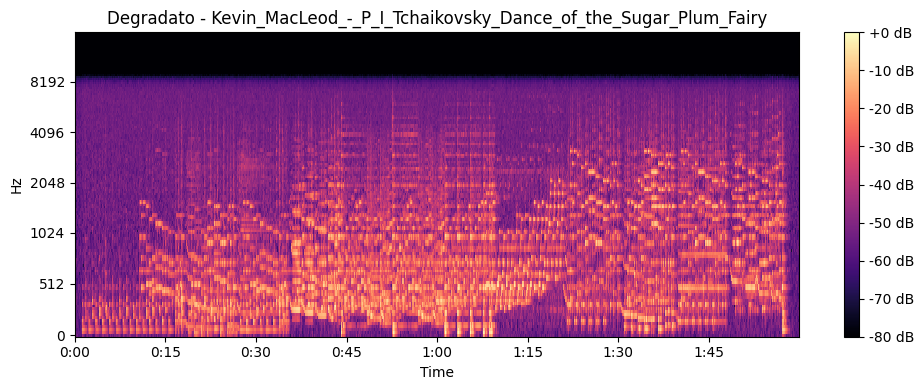

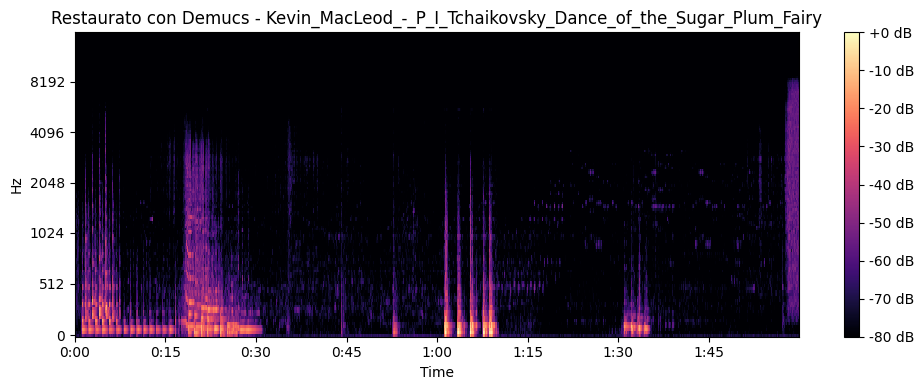

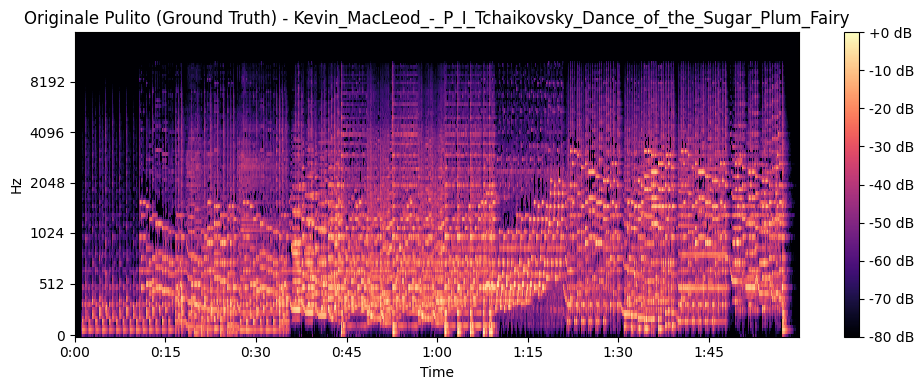

ANALISI PER: "Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra)"


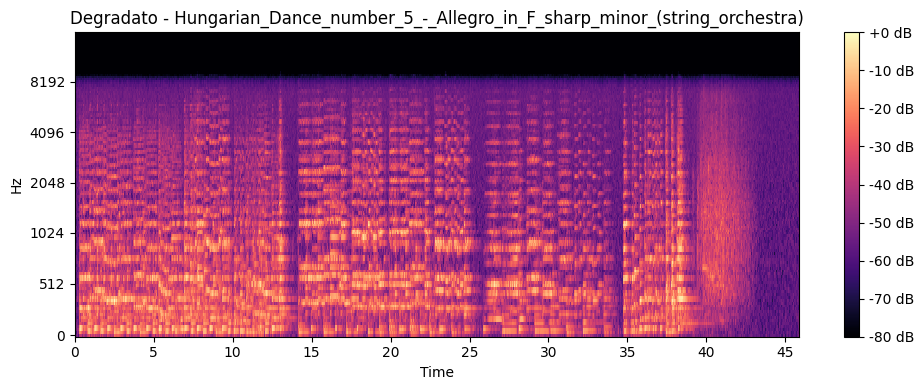

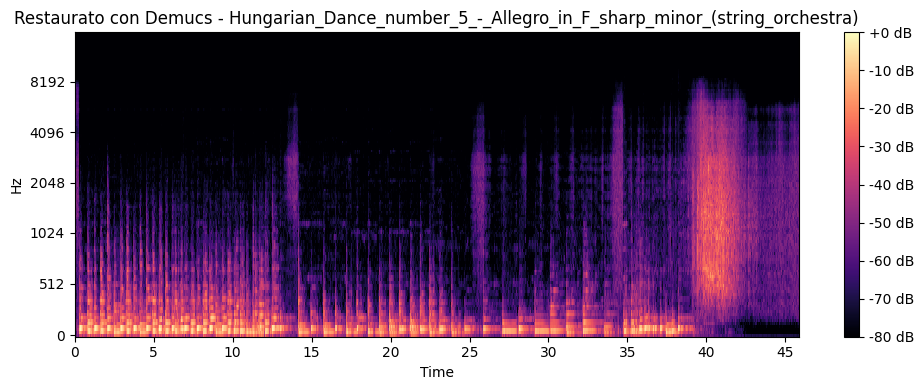

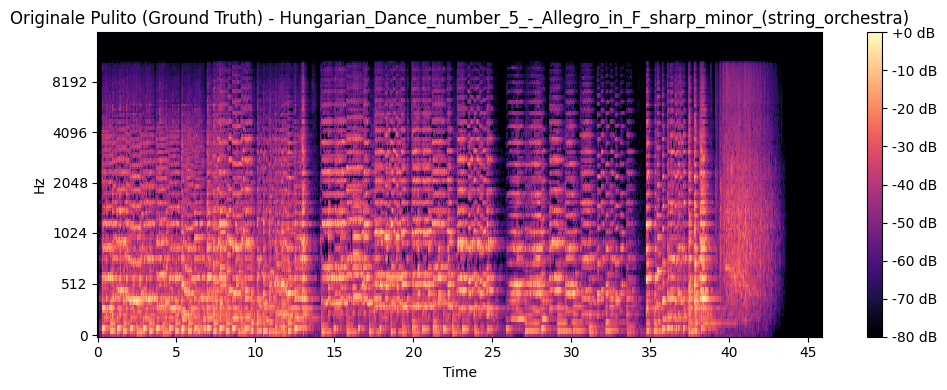

ANALISI PER: "Kevin_MacLeod_-_Vibe_Ace"


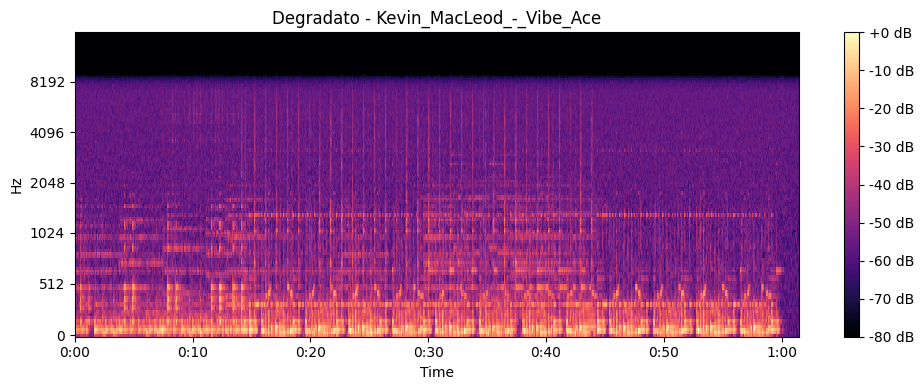

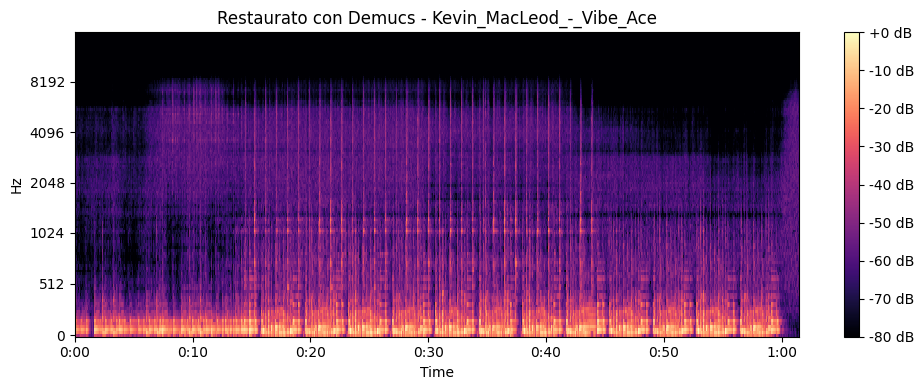

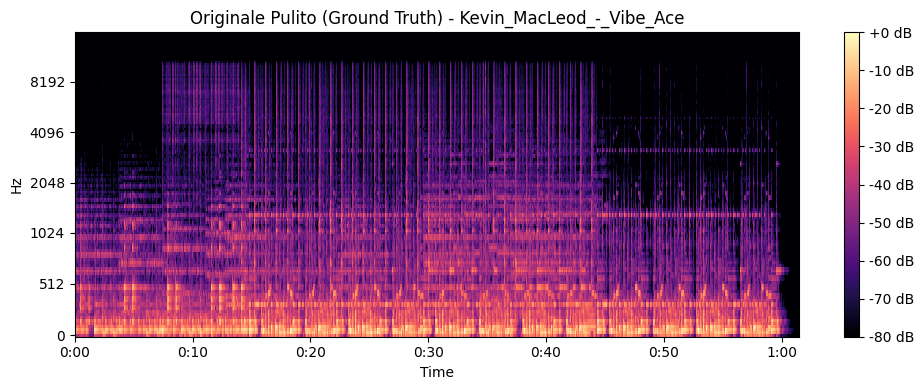

In [15]:
def plot_spectrogram(filepath, title):
   # Carica un file audio e ne visualizza lo spettrogramma in scala Mel.
    if not filepath or not Path(filepath).exists():
        print(f"File non trovato per il plot: {title}")
        return
    try:
        y, sr = librosa.load(filepath, sr=32000) # Assicuriamoci di usare la stessa sr
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=16000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        fig, ax = plt.subplots(figsize=(10, 4))
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=16000, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set_title(title)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Errore durante la creazione dello spettrogramma per {title}: {e}")

# Creiamo i plot per ogni set di file
for filename, paths in file_paths.items():
    print("="*50)
    print(f"ANALISI PER: \"{filename}\"")
    print("="*50)
    plot_spectrogram(paths.get("degraded"), f"Degradato - {filename}")
    plot_spectrogram(paths.get("restored"), f"Restaurato con Demucs - {filename}")
    plot_spectrogram(paths.get("clean"), f"Originale Pulito (Ground Truth) - {filename}")

## **4.2 Valutazione Quantitativa: Analisi Completa**

In questa cella vengono caricati i file audio originali, degradati e restaurati. Vengono convertiti in mono e comparati usando due diverse metriche standard nel settore audio:
* **Signal-to-distortion ratio (SDR)**: una misura che valuta la qualità di un audio restaurato rispetto all'originale, usando la formula  $SDR_{dB} = 10 \log_{10} \left( \frac{||s_{target}||^2}{||s_{restaurato} - s_{target}||^2} \right)$. Più il valore SDR è alto e minore è la distorsione.
* **Scale-Invariant SDR (SI-SDR)**: una misura più robusta dell'SDR, ormai standar per la separazione di sorgenti. L'SI-SDR è insensibile alle differenze globali di volume tra segnale stimato e quello di riferimento, abbiamo quindi una misura più fedele. Si usa la formula $s_{target\_proj} = \frac{\langle \hat{s}_{restored}, s_{target} \rangle}{||\hat{s}_{restored}||^2} \hat{s}_{restored}$

In [16]:
sdr_metric = SignalDistortionRatio()
snr_metric = SignalNoiseRatio()
si_sdr_metric = ScaleInvariantSignalDistortionRatio()

print("="*50)
print("ANALISI QUANTITATIVA DEI RISULTATI")
print("="*50)
print("Le metriche misurano la somiglianza con l'audio ORIGINALE PULITO. Valori più alti sono migliori.")

# Lista per conservare i risultati
results = []

for filename, paths in file_paths.items():
    if not all(paths.get(key) and Path(paths[key]).exists() for key in ["clean", "degraded", "restored"]):
        print(f"--- Saltando {filename} (uno o più file mancanti) ---")
        continue

    # CARICAMENTO E STANDARDIZZAZIONE A MONO
    try:
        original_clean, sr = torchaudio.load(paths["clean"])
        degraded_audio, _ = torchaudio.load(paths["degraded"])
        restored_audio, _ = torchaudio.load(paths["restored"])

        target = torch.mean(original_clean, dim=0, keepdim=True)
        degraded = torch.mean(degraded_audio, dim=0, keepdim=True)
        restored = torch.mean(restored_audio, dim=0, keepdim=True)

    except Exception as e:
        print(f"Errore durante il caricamento dei file per {filename}: {e}, verrà saltato")
        continue

    #  Allineiamo le lunghezze
    min_len = min(target.shape[1], degraded.shape[1], restored.shape[1])
    target, degraded, restored = target[:, :min_len], degraded[:, :min_len], restored[:, :min_len]

    #  Calcoliamo le metriche
    # Baseline: Degradato vs Originale
    sdr_degraded = sdr_metric(degraded, target).item()
    si_sdr_degraded = si_sdr_metric(degraded, target).item()
    # Performance: Restaurato vs Originale
    sdr_restored = sdr_metric(restored, target).item()
    si_sdr_restored = si_sdr_metric(restored, target).item()

    results.append({
        "File": filename,
        "SDR (Degradato)": sdr_degraded,
        "SDR (Restaurato)": sdr_restored,
        "Miglioramento SDR": sdr_restored - sdr_degraded,
        "SI-SDR (Degradato)": si_sdr_degraded,
        "SI-SDR (Restaurato)": si_sdr_restored,
        "Miglioramento SI-SDR": si_sdr_restored - si_sdr_degraded,
    })

    print(f"\n--- Risultati per: {filename} ---")
    print(f"  Qualità Degradata -> SDR: {sdr_degraded:.2f} dB | SI-SDR: {si_sdr_degraded:.2f} dB")
    print(f"  Qualità Restaurata -> SDR: {sdr_restored:.2f} dB | SI-SDR: {si_sdr_restored:.2f} dB")
    print(f"  Miglioramento Netto -> SDR: {sdr_restored - sdr_degraded:+.2f} dB | SI-SDR: {si_sdr_restored - si_sdr_degraded:+.2f} dB")


if results:

    df = pd.DataFrame(results).round(2)
    display_cols = [
        "File", "SDR (Restaurato)", "Miglioramento SDR",
        "SI-SDR (Restaurato)", "Miglioramento SI-SDR"
    ]
    print("\n\nTabella Riassuntiva (Tutte le metriche sono vs l'Originale Pulito)")
    display(df[display_cols])
else:
    print("\nNessun risultato da visualizzare.")

ANALISI QUANTITATIVA DEI RISULTATI
Le metriche misurano la somiglianza con l'audio ORIGINALE PULITO. Valori più alti sono migliori.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r


--- Risultati per: Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy ---
  Qualità Degradata -> SDR: -35.88 dB | SI-SDR: -53.67 dB
  Qualità Restaurata -> SDR: -30.65 dB | SI-SDR: -58.02 dB
  Miglioramento Netto -> SDR: +5.23 dB | SI-SDR: -4.35 dB

--- Risultati per: Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra) ---
  Qualità Degradata -> SDR: -36.01 dB | SI-SDR: -58.70 dB
  Qualità Restaurata -> SDR: -34.47 dB | SI-SDR: -43.80 dB
  Miglioramento Netto -> SDR: +1.54 dB | SI-SDR: +14.90 dB

--- Risultati per: Kevin_MacLeod_-_Vibe_Ace ---
  Qualità Degradata -> SDR: -32.77 dB | SI-SDR: -64.06 dB
  Qualità Restaurata -> SDR: -22.66 dB | SI-SDR: -29.63 dB
  Miglioramento Netto -> SDR: +10.11 dB | SI-SDR: +34.43 dB


--- Tabella Riassuntiva (Tutte le metriche sono vs l'Originale Pulito) ---


,File,SDR (Restaurato),Miglioramento SDR,SI-SDR (Restaurato),Miglioramento SI-SDR
0,Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_S...,-30.65,5.23,-58.02,-4.35
1,Hungarian_Dance_number_5_-_Allegro_in_F_sharp_...,-34.47,1.54,-43.80,14.90
2,Kevin_MacLeod_-_Vibe_Ace,-22.66,10.11,-29.63,34.43


## **4.3 Analisi del Segnale Residuo (Cosa ha sbagliato il modello?)**
Nella seguente cella viene caricato l'audio originale e la versione restaurata per poter applicare la formula del residuo r = $s_{target}$ - $s_{restaurato}$. Il residuo è tutto ciò che il nostro modello non è riuscito a restaurare, possiamo quindi confermare, osservando lo spettrogramma, che il modello non è riuscito a restaurare adeguatamente le basse frequenze.


 Analisi del Segnale di Errore (Residuo)

Residuo per: Kevin_MacLeod_-_P_I_Tchaikovsky_Dance_of_the_Sugar_Plum_Fairy


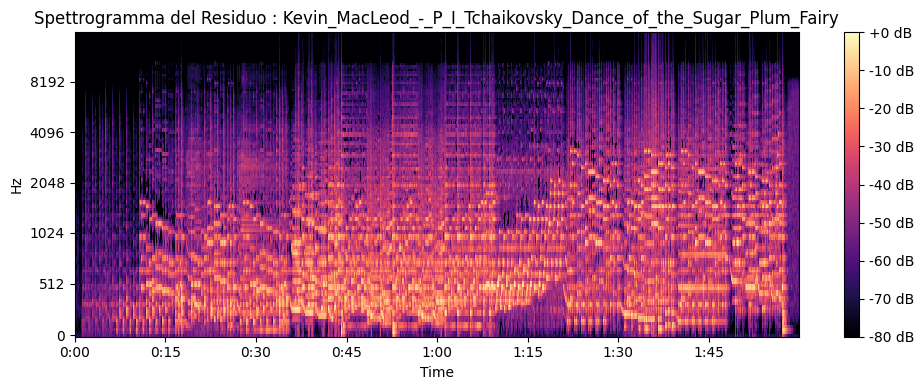


Residuo per: Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra)


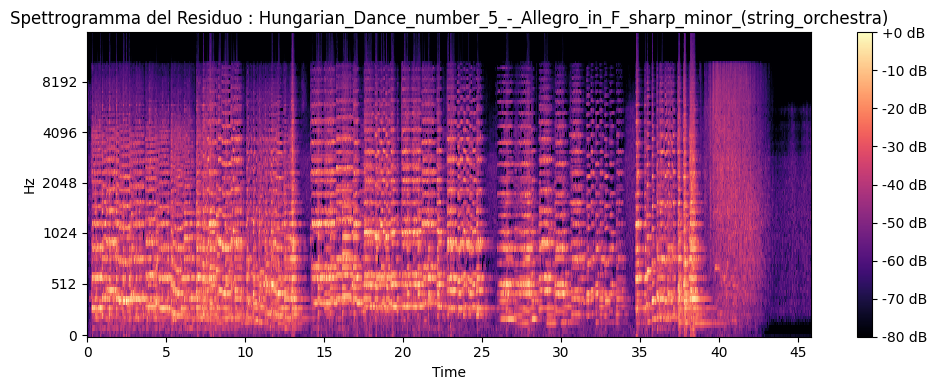


Residuo per: Kevin_MacLeod_-_Vibe_Ace


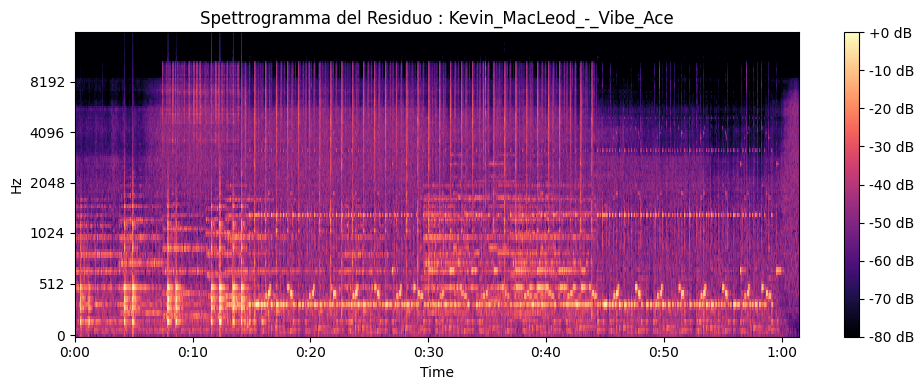

In [17]:

print("\n Analisi del Segnale di Errore (Residuo)")
residual_dir = Path("restored_outputs/residuals")
residual_dir.mkdir(exist_ok=True)

for filename, paths in file_paths.items():
    if not paths.get("restored"): continue

    x_restored, sr = load_mono(Path(paths["restored"]), sr=32000)
    x_clean, _ = load_mono(Path(paths["clean"]), sr=32000)

    # Allineiamo le lunghezze
    min_len = min(len(x_restored), len(x_clean))
    x_restored, x_clean = x_restored[:min_len], x_clean[:min_len]

    # Calcoliamo il segnale di errore
    residual_signal = x_clean - x_restored

    # Salviamo il segnale di errore come un file audio
    residual_path = residual_dir / f"{filename}_residual.wav"
    # NOTA: Potrebbe essere necessario amplificare il residuo per sentirlo bene
    save_wav_safe(residual_path, residual_signal * 5, sr) # Amplifichiamo di 5x

    file_paths[filename]["residual"] = str(residual_path)

    print(f"\nResiduo per: {filename}")
    plot_spectrogram(str(residual_path), f"Spettrogramma del Residuo : {filename}")

## Conclusioni

In conclusione, questo progetto ha confermato l'utilità di una pipeline di restauro audio basata sulla riconversione di Demucs.Grazie allo studio degli spettrogrammi e  del residuo notiamo che il modello ha difficoltà nel restaurare le basse frequenze, soprattutto con file audio complessi, ma è molto efficace nel restaurare le alte frequenze.